In [38]:
%load_ext autoreload
%autoreload 2

import os
import subprocess
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

%aimport xclone_config
project_config = xclone_config
os.chdir(project_config.ROOT)

from collections import Counter, defaultdict, OrderedDict
import itertools
from itertools import product as cartesian
import multiprocessing as mp
import pickle

import numba
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as sps
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

import toolkit
import util
from workspace.workspace_manager import WorkspaceManager

sns.set()

workspace = {}
for modality in ["scDNA", "scRNA"]:
    workspace.update({ 
        modality : WorkspaceManager(
            task_name="classification",
            experiment_info={
                "sample" : "STP_G&T",
                "modality" : modality
            },
            verbose=True
        )
    })
    workspace[modality].load_workspace()
    
assert workspace["scDNA"].experiment_info["sample"]\
        == workspace["scRNA"].experiment_info["sample"],\
    "scDNA and scRNA workspaces store different samples"

sample_tag = workspace["scDNA"].experiment_info["sample"]
print(f"Currently working on {sample_tag}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Currently working on STP_G&T


In [39]:
data = {}
for modality in ["scDNA", "scRNA"]:
    data[modality] = {
        data_name :
        util.pickle_load(data_dump).to_dense()
        for data_name, data_dump in tqdm_notebook(
            workspace[modality].tmp_data.items(),
            f"{modality}, loading datasets into RAM"
        )
    } 
    data[modality]["block_counts"]["BLOCK_ID"] = data[modality]["block_counts"]["BLOCK_ID"].astype(str)
data["scDNA"]["blocks"]["BLOCK_ID"] = data["scDNA"]["blocks"]["BLOCK_ID"].astype(str)

In [3]:
print(data["scDNA"]["blocks"].shape)

(16356, 4)


In [40]:
id_to_barcode = dict(data["scDNA"]["clustering"][["CELL_ID", "BARCODE"]].values)
for modality in ["scDNA", "scRNA"]:
    print(f"{modality}: {data[modality]['block_counts'].shape}")
    data[modality]["block_counts"].rename(
        columns={
            f"{id}_ad" : f"{barcode}_ad"
            for id, barcode in id_to_barcode.items()
        }, 
        inplace=True
    )
    data[modality]["block_counts"].rename(
        columns={
            f"{id}_dp" : f"{barcode}_dp"
            for id, barcode in id_to_barcode.items()
        }, 
        inplace=True
    )
    assert (data[modality]["block_counts"].shape[0] 
            == data["scDNA"]["blocks"].shape[0])
    data[modality]["block_counts"] = pd.merge(
        data[modality]["block_counts"],
        data["scDNA"]["blocks"][["BLOCK_ID", "CHROM", "START", "END"]],
        on=["BLOCK_ID"]
    )

scDNA: (16356, 193)
scRNA: (16356, 193)


In [5]:
data["scDNA"]["sc_cnv"].head()

,CHROM,START,END,A10,A11,A12,A2,A3,A4,A5,...,H1,H10,H2,H3,H4,H5,H6,H7,H8,H9
0,1,762988,794826,2,2,2,2,2,2,2,...,2,0,0,2,1,2,2,2,2,2
1,1,803451,812283,2,2,2,2,2,2,2,...,2,0,0,2,1,2,2,2,2,2
2,1,840214,851356,2,2,2,2,2,2,2,...,2,0,0,2,1,2,2,2,2,2
3,1,852245,856396,2,2,2,2,2,2,2,...,2,0,0,2,1,2,2,2,2,2
4,1,860260,894689,2,2,2,2,2,2,2,...,2,0,0,2,1,2,2,2,2,2


In [6]:
faulty_barcodes_mask = data["scDNA"]["sc_cnv"].iloc[:, 3:].describe().loc["50%"] < 2
faulty_barcodes = data["scDNA"]["sc_cnv"].columns[3:][faulty_barcodes_mask]
faulty_barcodes

Index(['C3', 'C6', 'D2', 'E6', 'E7', 'F11', 'F4', 'F8', 'G10', 'H10', 'H2',
       'H6'],
      dtype='object')

In [7]:
data[modality]["block_counts"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16356 entries, 0 to 16355
Columns: 196 entries, BLOCK_ID to END
dtypes: float64(192), int64(3), object(1)
memory usage: 24.6+ MB


In [41]:
for modality in ["scDNA", "scRNA"]:
    count_matrix = toolkit.extract_counts(
        data[modality]["block_counts"]
    )
    is_all_missing = np.all(
        np.isnan(count_matrix) | (count_matrix == 0), 
        axis=1
    )
    data[modality]["block_counts"] =\
        data[modality]["block_counts"][~is_all_missing] 
    data[modality]["block_counts"].reset_index(drop=True, inplace=True)
    print(f"{100. * np.mean(is_all_missing)}% "
          f"blocks were missing in {modality}")

10.589386157984837% blocks were missing in scDNA
45.99535338713622% blocks were missing in scRNA


In [42]:
common_blocks = (set(data["scDNA"]["block_counts"].BLOCK_ID) 
                & set(data["scRNA"]["block_counts"].BLOCK_ID))

print("Datasets have {} blocks in common".format(len(common_blocks)))

for modality in workspace.keys():
    data[modality]["block_counts"] = util.filter_by_isin(
        data[modality]["block_counts"], 
        "BLOCK_ID", 
        common_blocks
    ).reset_index(drop=True)

common_block_ids = data["scDNA"]["block_counts"]["BLOCK_ID"].values.astype(int)
    
assert (data["scDNA"]["block_counts"].shape[0] 
        == data["scRNA"]["block_counts"].shape[0])

Datasets have 8620 blocks in common


In [43]:
# barcodes_with_labels = data["scDNA"]["clustering"]["BARCODE"]
barcodes_with_labels = np.setdiff1d(
    data["scDNA"]["sc_cnv"].columns[3:], 
    faulty_barcodes
)
data["scDNA"]["sc_cnv"] = data["scDNA"]["sc_cnv"][
    ["CHROM", "START", "END"] 
    + list(barcodes_with_labels)
]
for modality in ["scDNA", "scRNA"]:
    data[modality]["block_counts"] = toolkit.filter_barcodes(
        data[modality]["block_counts"],
        barcodes_with_labels
    )

In [11]:
# rodata_dir = "/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/"\
#              f"data/raw/{sample_tag}/scDNA"
# CNV_prime_parts = [
#     pd.read_csv(
#         f"{rodata_dir}/TabHaplotypeblock_with_phasedSNPs_1.bed", 
#         usecols=[0, 1, 2],
#         names=["CHROM", "START", "END"],
#         sep='\t'
#     ).drop_duplicates().reset_index(drop=True)
# ]
# for i in tqdm_notebook(range(9), "reading CNV information"):
#     snp_cnv = pd.read_csv(
#         f"{rodata_dir}/TabHaplotypeblock_with_phasedSNPs_{i + 1}.bed", 
#         usecols=[0, 1, 2, 3],
#         names=["CHROM", "START", "END", "CNV"],
#         sep='\t'
#     )
#     snp_cnv.drop_duplicates(inplace=True)
#     snp_cnv.reset_index(inplace=True, drop=True)
#     print(snp_cnv.shape, np.bincount(snp_cnv["CNV"]).argmax())
#     CNV_prime_parts.append(snp_cnv["CNV"].rename(columns={"CNV" : f"{i + 1}"}))
# CNV_prime_df = pd.concat(CNV_prime_parts, axis=1).rename(
#     columns={i : f"{i+1}" for i in range(9)}
# )
# CNV_prime_df = data["scDNA"]["block_counts"][["BLOCK_ID", "CHROM", "START", "END"]].merge(
#     CNV_prime_df, on=["CHROM", "START", "END"]
# )

# CNV_prime = CNV_prime_df.drop(
#     columns=["BLOCK_ID", "CHROM", "START", "END"]
# ).values.astype(float)
# is_all_missing = np.all(
#     np.isnan(CNV_prime) | (CNV_prime == 0),
#     axis=1
# )
# CNV_prime = CNV_prime[~is_all_missing]
# CNV_prime_df = CNV_prime_df[~is_all_missing]
# CNV_prime_df.reset_index(drop=True, inplace=True)
# util.pickle_dump(
#     CNV_prime_df, 
#     "/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/"
#     f"data/processed/{sample_tag}/scDNA/CNV_prime_df.pkl"
# )
# util.pickle_dump(
#     CNV_prime, 
#     "/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/"
#     f"data/processed/{sample_tag}/scDNA/CNV_prime.pkl"
# )

# CNV_DNA_df = util.pickle_load(
#     "/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/"
#     f"data/processed/{sample_tag}/scDNA/CNV_DNA_df.pkl"
# )
# CNV_DNA = util.pickle_load(
#     "/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/"
#     f"data/processed/{sample_tag}/scDNA/CNV_DNA.pkl"
# )
# T = util.pickle_load(
#     "/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/"
#     f"data/processed/{sample_tag}/scDNA/T.pkl"
# )

In [44]:
CNV_DNA_df = data["scDNA"]["sc_cnv"]
CNV_DNA_df.head()

,CHROM,START,END,A10,A11,A12,A2,A3,A4,A5,...,G7,G8,G9,H1,H3,H4,H5,H7,H8,H9
0,1,762988,794826,2,2,2,2,2,2,2,...,2,2,2,2,2,1,2,2,2,2
1,1,803451,812283,2,2,2,2,2,2,2,...,2,2,2,2,2,1,2,2,2,2
2,1,840214,851356,2,2,2,2,2,2,2,...,2,2,2,2,2,1,2,2,2,2
3,1,852245,856396,2,2,2,2,2,2,2,...,2,2,2,2,2,1,2,2,2,2
4,1,860260,894689,2,2,2,2,2,2,2,...,2,2,2,2,2,1,2,2,2,2


In [13]:
data["scDNA"]["block_counts"].head()

,BLOCK_ID,A10_ad,A10_dp,A8_ad,A8_dp,A9_ad,A9_dp,B1_ad,B1_dp,B10_ad,...,H5_dp,H7_ad,H7_dp,H8_ad,H8_dp,H9_ad,H9_dp,CHROM,START,END
0,0,0.0,1.0,0.0,7.0,NaN,NaN,0.0,3.0,5.0,...,1.0,0.0,1.0,1.0,1.0,NaN,NaN,1,762988,794826
1,2,2.0,3.0,0.0,1.0,0.0,4.0,1.0,1.0,0.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,840214,851356
2,3,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,1.0,0.0,2.0,1.0,3.0,1,852245,856396
3,5,5.0,8.0,1.0,1.0,NaN,NaN,0.0,1.0,0.0,...,NaN,1.0,5.0,NaN,NaN,2.0,2.0,1,901877,917497
4,8,1.0,2.0,0.0,1.0,NaN,NaN,NaN,NaN,2.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,948803,949920


In [45]:
for modality in ["scDNA", "scRNA"]:
    data[modality]["block_counts"] = data[modality]["block_counts"].merge(
        CNV_DNA_df[["CHROM", "START", "END"]], 
        on=["CHROM", "START", "END"]
    )
    CNV_DNA_df = pd.merge(
        data[modality]["block_counts"][["CHROM", "START", "END"]],
        CNV_DNA_df
    )

In [46]:
data["scDNA"]["clustering"] = data["scDNA"]["clustering"][
    np.isin(data["scDNA"]["clustering"]["BARCODE"], 
            toolkit.extract_barcodes(data["scDNA"]["block_counts"]))
].reset_index(drop=True)
data["scDNA"]["clustering"].shape[0]

77

In [16]:
cluster_to_best_covered_scDNA = {} 
data["scDNA"]["clustering"]["LABEL"] = data["scDNA"]["clustering"]["LABEL"].astype(str)
for label in sorted(data["scDNA"]["clustering"]["LABEL"].unique().astype(str)):
    if label == "6": 
        continue
    barcodes_in_cluster = data["scDNA"]["clustering"][
        data["scDNA"]["clustering"]["LABEL"] == label
    ]["BARCODE"].values
    dp_in_cluster = toolkit.extract_counts(
        toolkit.filter_barcodes(
            data["scRNA"]["block_counts"],
            barcodes_in_cluster
        )
    )
    cluster_to_best_covered_scDNA[label] = barcodes_in_cluster[
        np.argmax(np.sum(np.nan_to_num(dp_in_cluster), axis=0)) 
    ]
top_cell_barcodes = list(cluster_to_best_covered_scDNA.values())
top_cell_mask = np.isin(
    toolkit.extract_barcodes(data["scDNA"]["block_counts"]), 
    top_cell_barcodes
)
cluster_to_best_covered_scDNA

{'1': 'D7', '2': 'B2', '3': 'F10', '4': 'D5', '5': 'E8', '8': 'E3', '9': 'C1'}

In [104]:
top_cell_barcodes = toolkit.extract_barcodes(data["scDNA"]["block_counts"])
top_cell_mask = np.ones(
    toolkit.extract_barcodes(data["scDNA"]["block_counts"]).size
).astype(np.bool)

In [109]:
import scipy.stats as sps

I_DNA = np.ravel([
    data["scDNA"]["clustering"]["LABEL"][
        data["scDNA"]["clustering"]["BARCODE"] == barcode
    ].astype(int).values - 1
    for barcode in top_cell_barcodes
])
CNV_DNA = CNV_DNA_df.drop(columns=["CHROM", "START", "END"]).loc[:, top_cell_mask].astype(np.float64)
for label in data["scDNA"]["clustering"]["LABEL"].unique():
    barcodes_in_cluster = data["scDNA"]["clustering"][
        data["scDNA"]["clustering"]["LABEL"] == label
    ]["BARCODE"].values
    mode_cn = sps.mode(CNV_DNA[barcodes_in_cluster].values, axis=1)[0]
    CNV_DNA[label] = mode_cn
CNV_DNA = CNV_DNA[sorted(data["scDNA"]["clustering"]["LABEL"].unique())].values

no_nans_gene_mask = np.all((~np.isnan(CNV_DNA)) & (~(CNV_DNA == 0)), axis=1)
CNV_DNA = CNV_DNA[no_nans_gene_mask]
D_DNA = np.nan_to_num(toolkit.extract_counts(
    data["scDNA"]["block_counts"]
).values)[:, top_cell_mask][no_nans_gene_mask, :]
D_RNA = np.nan_to_num(toolkit.extract_counts(
    data["scRNA"]["block_counts"]
).values)[:, top_cell_mask][no_nans_gene_mask, :]

A_DNA = np.nan_to_num(toolkit.extract_counts(
    data["scDNA"]["block_counts"],
    suffix="ad"
).values)[:, top_cell_mask][no_nans_gene_mask, :]
A_RNA = np.nan_to_num(toolkit.extract_counts(
    data["scRNA"]["block_counts"],
    suffix="ad"
).values)[:, top_cell_mask][no_nans_gene_mask, :]
T_max = 5
CNV_DNA[CNV_DNA == 2] = np.nan
I_DNA[I_DNA > 6] -= 1

In [22]:
print(f"RAW, ({I_DNA.size} cells)")
display(pd.DataFrame(
    np.column_stack((
        np.arange(CNV_DNA.shape[1]), 
        np.round(100 * np.mean(np.isnan(CNV_DNA), axis=0))
    )), columns=["cluster", "% of NaNs"]
))

cells_to_keep = (I_DNA != 6)
clusters_to_keep = [0, 1, 2, 3, 4, 5, 7, 8]

D_DNA = D_DNA[:, cells_to_keep]
D_RNA = D_RNA[:, cells_to_keep]

A_DNA = A_DNA[:, cells_to_keep]
A_RNA = A_RNA[:, cells_to_keep]

I_DNA = I_DNA[cells_to_keep]
I_DNA[I_DNA > 6] = I_DNA[I_DNA > 6] - 1

CNV_DNA = CNV_DNA[:, clusters_to_keep]
# T = T[:, clusters_to_keep]

# print(f"W/O cluster 6 of dead cells ({I_DNA.size} cells remain)")
# display(pd.DataFrame(
#     np.column_stack((
#         np.arange(CNV_DNA.shape[1]), 
#         np.round(100 * np.mean(np.isnan(CNV_DNA), axis=0))
#     )), columns=["cluster", "% of NaNs"]
# ))

print(f"RAW: ({D_DNA.shape[0]} blocks in each cell)")

# idx = np.all(T > 0, axis=1) * np.all(~np.isnan(T), axis=1)

CNV_DNA = CNV_DNA[idx, :]
T = T[idx, :]
D_RNA = np.nan_to_num(D_RNA[idx, :])
D_DNA = np.nan_to_num(D_DNA[idx, :])

A_RNA = np.nan_to_num(A_RNA[idx, :])
A_DNA = np.nan_to_num(A_DNA[idx, :])

print(f"ONLY NON-MISSING: ({D_DNA.shape[0]} blocks in each cell)")

RAW, (7 cells)


,cluster,% of NaNs
0,0.0,0.0
1,1.0,0.0
2,2.0,0.0
3,3.0,0.0
4,4.0,0.0
5,5.0,0.0
6,6.0,0.0


IndexError: index 7 is out of bounds for axis 1 with size 7

In [13]:
def classification_report(labels, title, outfile=None, show=True):
                
        sns.set(style="whitegrid", font_scale=1.5);
        fig, ax = plt.subplots(2, 1, figsize=(20,30))
        ax[0].set_title("Cluster label assigned by XClone", fontsize=20)
        
        palette =  {
            1 : "xkcd:orange",
            2 : "xkcd:azure",
            3 : "xkcd:cyan",
            4 : "xkcd:yellow",
            5 : "xkcd:blue",
            6 : "xkcd:red",
            7 : "xkcd:pink",
            8 : "xkcd:grey",
            9 : "xkcd:black"
        }
        
        sns.countplot(
            labels, 
            palette=palette,
            ax=ax[0]
        )

        ax[1].set_title(title)
        
        sns.scatterplot(
            x="TSNE_1", y="TSNE_2", 
            hue=labels, 
            data=data["scRNA"]["clustering"], 
            legend="full",
            palette=palette,
            ax=ax[1]
        );
        ax[1].legend().get_frame().set_facecolor("white");
        ax[1].legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left")
        fig.subplots_adjust(right=0.75)
        if outfile is not None:
            fig.savefig(outfile, format=outfile.split('.')[-1], dpi=300)
        if show == True:
            plt.show()
        plt.close()
        plt.clf()

In [24]:
CNV_DNA

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

In [111]:
%%time
from classification.xclone_model.xclone_distrib import XCloneDistrib
from classification.xclone_model.xclone_gibbs_sampler import XCloneGibbsSampler
from classification.xclone_model.xclone_engine import XCloneEngine
from classification.xclone_model.xclone_criterions import accuracy_criterion, loglik_criterion

datadict = {
    "D_DNA" : D_DNA,
    "D_RNA" : D_RNA,
    "A_DNA" : A_DNA,
    "A_RNA" : A_RNA,
    "I_DNA" : I_DNA,
    "CNV_DNA" : CNV_DNA,
    "T_max" : T_max
}
params = XCloneDistrib(datadict)
sampler = XCloneGibbsSampler()

xclone = XCloneEngine(
    workspace_dict=workspace,
    params=params,
    sampler=sampler,
    criterion=loglik_criterion,
    report_dir="/icgc/dkfzlsdf/analysis/B260/users/v390v/"\
                "xclone/data/tmp/xclone/STP_G&T/"\
                "19_11_2019/afternoon_run/"\
                "all_cells_evo_dist_clustering_real_data_stat_phasing_genes_dropped_diploid_blocks/DNA_vs_RNA",
    verbose=True
)
xclone

CPU times: user 2.63 s, sys: 917 ms, total: 3.55 s
Wall time: 1.61 s


XCloneEngine, 2019-2020, Stegle Lab
Report dir: /icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/tmp/xclone/STP_G&T/19_11_2019/afternoon_run/all_cells_evo_dist_clustering_real_data_stat_phasing_genes_dropped_diploid_blocks/DNA_vs_RNA
This instance was created on 19/11/2019 14:34:25
Criterion: <function loglik_criterion at 0x7f8b8179d268>
DNA sample: STP_G&T
Cells in DNA sample: 77
RNA sample: STP_G&T
Cells in RNA sample: 77
Total number of CNV-haploblocks: 8260
Number of clones: 8
0 fitting iterations already passed
Sampler used: <class 'classification.xclone_model.xclone_gibbs_sampler.XCloneGibbsSampler'>
Initial total loglikelihood: -42.97420169269904
Current best total loglikelihood: -15.930772188435887

In [35]:
util.pickle_dump(
    params.D_DNA, 
    "/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/"
    f"data/processed/{sample_tag}/scDNA/top_coverage_in_cluster_D_DNA.pkl"
)
util.pickle_dump(
    params.A_DNA, 
    "/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/"
    f"data/processed/{sample_tag}/scDNA/top_coverage_in_cluster_A_DNA.pkl"
)
util.pickle_dump(
    params.D_RNA, 
    "/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/"
    f"data/processed/{sample_tag}/scDNA/top_coverage_in_cluster_D_RNA.pkl"
)
util.pickle_dump(
    params.A_RNA, 
    "/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/"
    f"data/processed/{sample_tag}/scDNA/top_coverage_in_cluster_A_RNA.pkl"
)
util.pickle_dump(
    params.T, 
    "/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/"
    f"data/processed/{sample_tag}/scDNA/top_coverage_in_cluster_T.pkl"
)
util.pickle_dump(
    params.CNV_DNA, 
    "/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/"
    f"data/processed/{sample_tag}/scDNA/top_coverage_in_cluster_CNV_DNA.pkl"
)
util.pickle_dump(
    params.I_DNA, 
    "/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/"
    f"data/processed/{sample_tag}/scDNA/top_coverage_in_cluster_I_DNA.pkl"
)
util.pickle_dump(
    params.T, 
    "/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/"
    f"data/processed/{sample_tag}/scDNA/top_coverage_in_cluster_T.pkl"
)

In [103]:
params.shapes

,PARAM,SHAPE
0,N,"(1,)"
1,A_DNA,"(8260, 77)"
2,D_DNA,"(8260, 77)"
3,R_DNA,"(8260, 77)"
4,M_DNA,"(1,)"
5,A_RNA,"(8260, 77)"
6,D_RNA,"(8260, 77)"
7,R_RNA,"(8260, 77)"
8,M_RNA,"(1,)"
9,logbincoeff_DNA,"(8260, 77)"


In [108]:
I_DNA

array([4, 0, 0, 1, 4, 2, 8, 0, 4, 7, 1, 0, 1, 4, 1, 0, 1, 0, 7, 5, 8, 8,
       0, 5, 5, 7, 1, 5, 4, 0, 7, 3, 2, 0, 2, 3, 5, 0, 1, 1, 4, 1, 7, 0,
       1, 7, 5, 2, 4, 5, 5, 2, 0, 8, 2, 3, 2, 2, 4, 7, 2, 3, 4, 1, 0, 2,
       0, 4, 1, 3, 1, 2, 5, 8, 3, 3, 2])

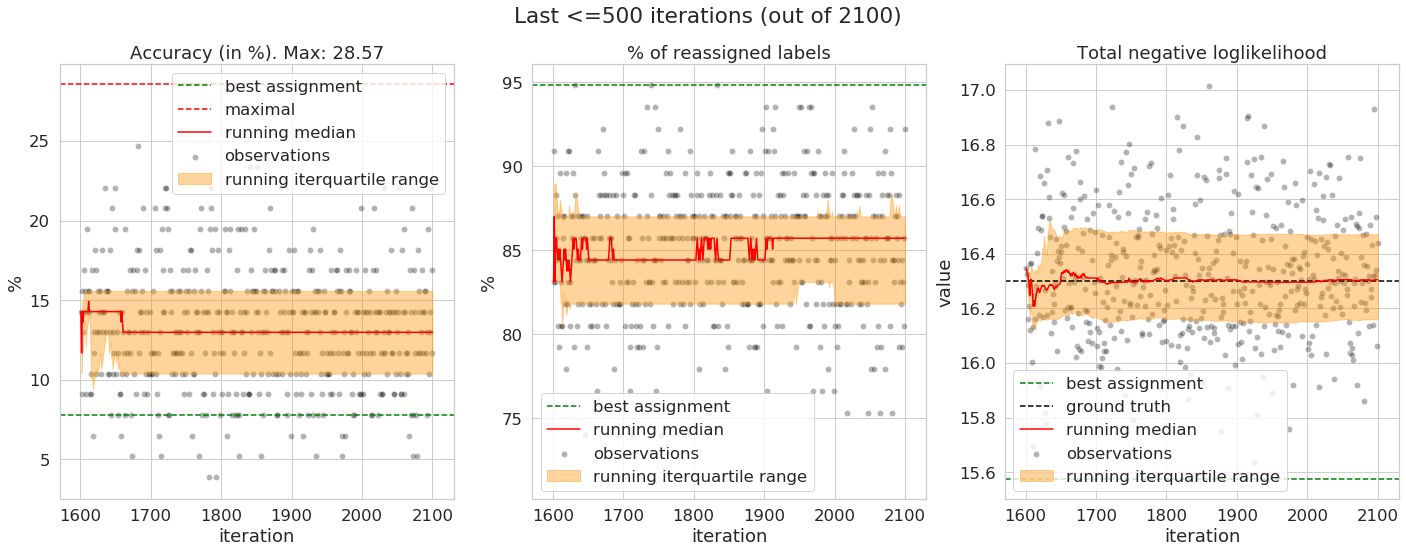

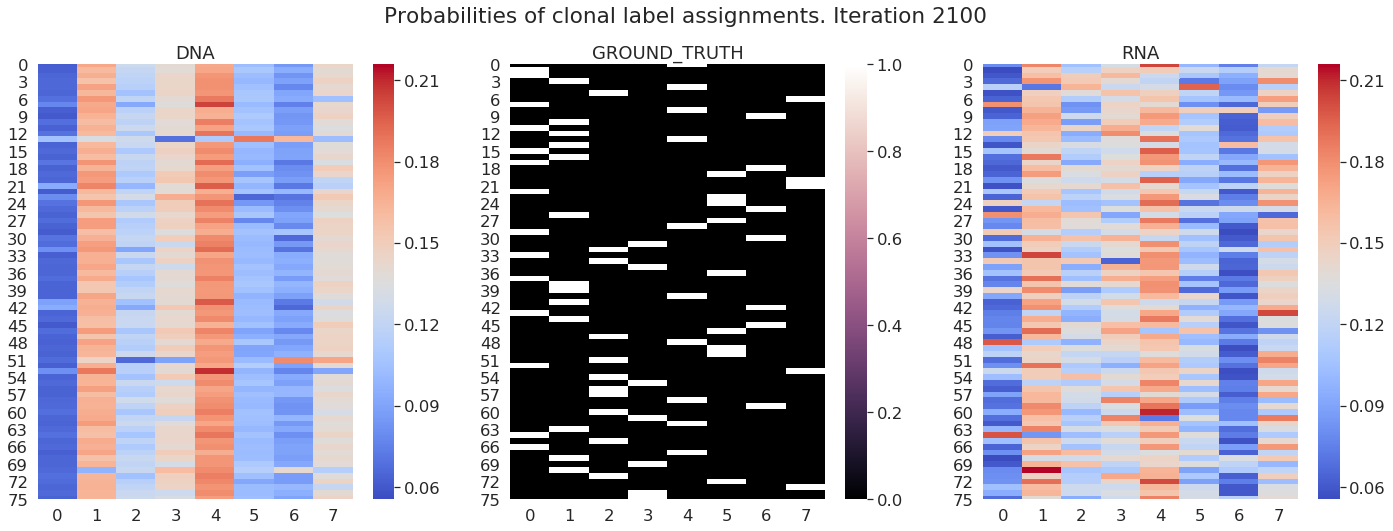

[-10.15869023  -5.41671572]


KeyboardInterrupt: 

In [112]:
%%time
%matplotlib inline

from classification.xclone_model.xclone_diagnostics import GTConvergenceTracker
sns.set(font_scale=1.5, style="whitegrid")

xclone.fit(10000, GTConvergenceTracker())

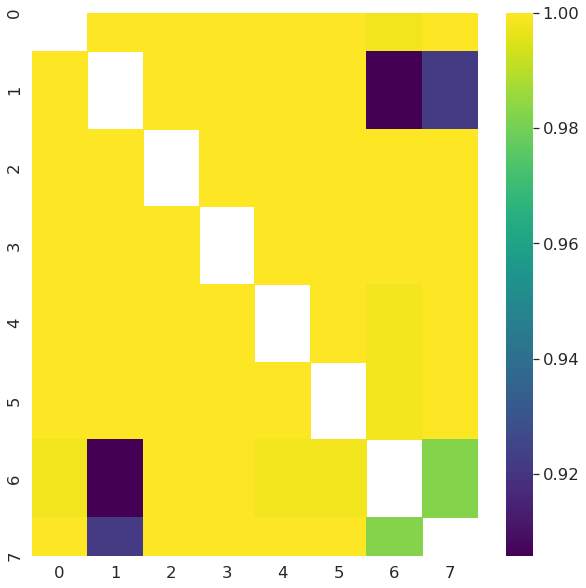

In [133]:
corr_mx = pd.DataFrame(CNV_DNA).corr().values
diag_ix, diag_iy = np.diag_indices(corr_mx.shape[0], 2)
corr_mx[diag_ix, diag_iy] = np.nan
plt.figure(figsize=(10,10))
sns.heatmap(corr_mx, cmap="viridis")